In [1]:
import json
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcl
import math
import numpy as np
import pandas as pd
import re

from ast import literal_eval
from itertools import product
from matplotlib.transforms import ScaledTranslation
from matplotlib.ticker import NullFormatter
from os import makedirs
from os.path import isdir, isfile
from pathlib import Path
from string import ascii_lowercase
from time import time
from tqdm import tqdm
from constants import *
from UTILS.mutils import njoin, str2bool, str2ls, create_model_dir, convert_train_history
from UTILS.mutils import collect_model_dirs, find_subdirs, load_model_files
from UTILS.figure_utils import matrixify_axs, label_axs
from plot_results import *

# Attention weights

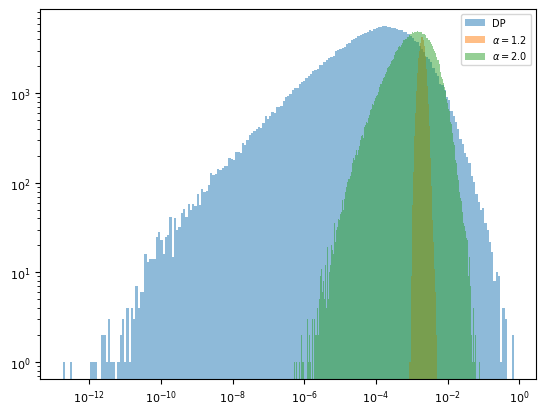

In [6]:
%matplotlib inline
# paths = [".droot/long_sequence/attn_graph_results_dp.npz", ".droot/long_sequence/attn_graph_results_1.2.npz", ".droot/long_sequence/attn_graph_results_2.0.npz"]

seed = 0
d = 16
shared_path = f'.droot/L-d-grid-v2/1L-hidden={d}-max_len=512-rescaled/config_qqv/imdb/layers=1-heads=1-qqv'
paths = [f"{shared_path}/opdpformer-imdb-qqv/model={seed}/attn_graph_results.npz",
         f"{shared_path}/oprdfnsformer-imdb-qqv-alpha=1.2-eps=1.0/model={seed}/attn_graph_results.npz",
         f"{shared_path}/oprdfnsformer-imdb-qqv-alpha=2.0-eps=1.0/model={seed}/attn_graph_results.npz"]



labels = ['DP', r'$\alpha = 1.2$', r'$\alpha = 2.0$']

fig, ax = plt.subplots()
for i, path in enumerate(paths):
# for i in [1,2]:
    path = paths[i]
    data = np.load(path)
    attn_weights = np.squeeze(data["attention_weights"])
    np.fill_diagonal(attn_weights, np.nan)
    bins = np.logspace(np.log10(np.nanmin(attn_weights)), np.log10(np.nanmax(attn_weights)), 200)
    # bins = np.logspace(-3, 0, 100)
    # print(np.nanmin(attn_weights), np.nanmax(attn_weights))
    # bins, counts = np.histogram(attn_weights.flatten(), bins=bins)
    ax.hist(attn_weights.flatten(), bins=bins, label=labels[i], alpha=0.5)
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()
plt.show()

# Shortest path matrix

In [6]:
import networkx as nx
# from mpl_toolkits.axes_grid1 import make_axes_locatable
import cmasher as cm

# paths = [".droot/length_500/attn_graph_results_1.2.npz", ".droot/length_500/attn_graph_results_2.0.npz", ".droot/length_500/attn_graph_results_dp.npz"]
# paths = [".droot/length_32/attn_graph_results_1.2.npz", ".droot/length_32/attn_graph_results_2.0.npz", ".droot/length_32/attn_graph_results_dp.npz"]

# parent_dir = 'U:/scratch/uu69/cq5024/projects/fractional-attn/nlp-tutorial'
shared_path = '.droot/L-d-grid-v2/1L-hidden=8-max_len=512-rescaled/config_qqv/imdb/layers=1-heads=1-qqv'
seed = 0
paths = [f"{shared_path}/oprdfnsformer-imdb-qqv-alpha=1.2-eps=1.0/model={seed}/attn_graph_results.npz",
         f"{shared_path}/oprdfnsformer-imdb-qqv-alpha=2.0-eps=1.0/model={seed}/attn_graph_results.npz",
         f"{shared_path}/opdpformer-imdb-qqv/model={seed}/attn_graph_results.npz"]

seq_len = 500
shortest_path_lengths = []
shortest_path_lengths_check = []  # for checking
for i in range(3):
# for i in range(1):
    # path = njoin(parent_dir,paths[i])
    path = paths[i]
    # ax = axs[i]

    data_all = np.load(path)

    # ----- 1. compute from scratch (for checking) -----
    # attn_weights = np.squeeze(data_all["attention_weights"])[:seq_len, :seq_len]
    # edge_weights = 1/np.abs(attn_weights)
    # np.fill_diagonal(edge_weights, 0)
    # G = nx.from_numpy_array(edge_weights, create_using=nx.DiGraph)
    # shortest_path_length = np.full(attn_weights.shape, np.inf)
    # np.fill_diagonal(shortest_path_length, 0)
    # for source in tqdm(range(shortest_path_length.shape[0])):
    #     lengths, shortest_paths = nx.single_source_dijkstra(G, source) # Compute shortest paths using Dijkstra's algorithm
    #     for target in lengths:
    #         shortest_path_length[source, target] = len(shortest_paths[target]) - 1
    # shortest_path_lengths_check.append(shortest_path_length)
    # ------------------------------------

    # ----- 2. load from data_all -----
    shortest_path_length = data_all["shortest_path_lengths"][-1].reshape(seq_len,seq_len)  # last one
    # ------------------------------------
    
    shortest_path_lengths.append(shortest_path_length)

In [ ]:
%matplotlib inline
from scipy.cluster.hierarchy import linkage, leaves_list
def agglomerative_reorder(distance_matrix, method="average"):
    """
    Perform agglomerative clustering on a distance matrix and 
    return a reordered matrix suitable for visualization.
    
    Parameters
    ----------
    distance_matrix : ndarray (n x n)
        Symmetric distance matrix.
    method : str
        Linkage method ('single', 'complete', 'average', 'ward', etc.).
        
    Returns
    -------
    reordered_matrix : ndarray (n x n)
        Distance matrix reordered according to clustering.
    order : ndarray (n,)
        The order of indices after clustering.
    """
    # Ensure distance matrix is square
    n, m = distance_matrix.shape
    assert n == m, "Distance matrix must be square"
    
    # Convert to condensed form (upper triangular as 1D vector)
    condensed = distance_matrix[np.triu_indices(n, k=1)]
    
    # Perform hierarchical clustering
    Z = linkage(condensed, method=method)
    
    # Get the order of leaves after clustering
    order = leaves_list(Z)
    
    # Reorder the distance matrix
    reordered_matrix = distance_matrix[np.ix_(order, order)]
    
    return reordered_matrix, order

titles = [r'$\alpha = 1.2$', r'$\alpha = 2.0$', 'DP']
gridspec = {'width_ratios': [1, 1, 1, 0.07]}
fig, axs = plt.subplots(1,4, gridspec_kw=gridspec, figsize=(6,1.9))
for i in range(3):
    ax = axs[i]
    shortest_path_length = shortest_path_lengths[i]
    im = ax.imshow(shortest_path_length, vmin=0, vmax=14, cmap=cm.torch_r, origin='lower')
    print("Max shortest path:", np.nanmax(shortest_path_length))
    # reordered_matrix, order = agglomerative_reorder(shortest_path_length, method="complete")
    # im = ax.imshow(reordered_matrix, vmin=0, vmax=14, cmap=cm.torch_r)
    print("Mean shortest path:", shortest_path_length.mean())
    ax.set_aspect(1)
    ax.set_title(titles[i])
    ax.set_xlabel(r'Position index $i$')
    ax.set_xticks([0,250,500])
    ax.set_yticks([0,250,500])
    if i == 0:
        ax.set_ylabel(r'Position index $j$')
        
cbar = fig.colorbar(im, cax=axs[3], fraction=0.000002)
cbar.ax.set_ylabel("Shortest path length")
cbar.ax.set_yticks([0, 7, 14])

plt.tight_layout()
from constants import FIGS_DIR
SAVE_DIR = njoin(FIGS_DIR, 'nlp-task')    
fig_file = 'shortest_path_matrix'
fig_file += '.pdf'
plt.savefig(njoin(SAVE_DIR, fig_file), bbox_inches='tight', dpi=500)
plt.show()

# torch_r 
# rainforest_r
# freeze_r
# arctic_r
# amethyst_r

Max shortest path: 3.0
Mean shortest path: 1.146296
Max shortest path: 9.0
Mean shortest path: 3.018836
Max shortest path: 14.0
Mean shortest path: 4.477396


# Diffusion map

i = 0
(500,)
[0.02650335 0.02737785 0.02850502 0.02909334 0.02963692 0.02972718
 0.03035915 0.03055931 0.03094171 0.03118109]
[0.24628896 0.25881475 0.26252308 0.27814996 0.28323922 0.2978041
 0.31373817 0.32054585 0.35875803 1.0000002 ]


i = 1
(500,)
[0.4999399  0.5415252  0.616853   0.73906356 0.7513485  0.7673357
 0.7742544  0.79862374 0.80421543 0.80812365]
[1.        1.        1.        1.0000001 1.0000002 1.0000002 1.0000002
 1.0000004 1.0000005 1.000001 ]


All bandwidths: [0.1, 0.1], seed = 4


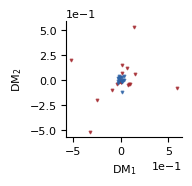

21 of the furthest embeddings in the sequence.


In [53]:
%matplotlib inline

seed = 4
d = 8
shared_path = f'.droot/L-d-grid-v2/1L-hidden={d}-max_len=512-rescaled/config_qqv/imdb/layers=1-heads=1-qqv'
paths = [f"{shared_path}/oprdfnsformer-imdb-qqv-alpha=1.2-eps=1.0/model={seed}", 
         f"{shared_path}/oprdfnsformer-imdb-qqv-alpha=2.0-eps=1.0/model={seed}"]
# paths = paths[1:]

fig, ax = plt.subplots(figsize=(1.5,1.5))
colors = ["#2E63A6", "#A4292F"]
# colors = colors[1:]

# i1, i2 = -1, -2
i1, i2 = -2, -3

tau = 0.1
bdwths = []
eigvalss = []
texts = []
for i in range(len(paths)):
    # model settings
    attn_setup, config, run_performance, train_setting = load_model_files(paths[i])
    alpha = attn_setup['alpha']

    data_all = np.load(njoin(paths[i], 'attn_graph_results.npz'))
    eigvals = data_all["eigvals"]
    eigvecs = data_all["diffusion_map"]
    bdwth = data_all["bdwth"].item()  # for checking bandwidth used
    bdwths.append(bdwth)
    X_len = data_all["X_len"].item()
    # distant tokens in the embeddint space
    far_xy_idxs = data_all["far_xy_idxs"]
    # filter out padding indices
    far_xy_idxs_filtered = far_xy_idxs[far_xy_idxs < X_len]

    # load texts
    with open(njoin(paths[i], 'text.txt'), 'r') as f:
        lines = f.readlines()
    # Optional: Remove newline characters from each line
    text = [line.strip() for line in lines]
    texts.append(text)  # for double-checking
    for wii, word in enumerate(text):
        if 'much' in word:
            break
    # diff = 2
    # txt_indices = np.array(list(range(wii - diff, wii + diff))) 
    txt_indices = np.array([wii, wii + 1]) 

    # order based on eigvals from large to small
    ii_sorted = eigvals.argsort()
    eigvals = eigvals[ii_sorted]
    eigvalss.append(eigvals)
    eigvecs = eigvecs[:,ii_sorted] 

    print(f'i = {i}')
    print(eigvals.shape)
    print(eigvals[0:10])
    print(eigvals[-10:])
    print('\n')

    # diffusion map embeddings
    diff_map_results = eigvals**tau * eigvecs

    ##### centered #####
    # centred_results = diff_map_results[txt_indices] - np.mean(diff_map_results[txt_indices], axis=0)
    centred_results = diff_map_results[far_xy_idxs_filtered] - np.mean(diff_map_results[far_xy_idxs_filtered], axis=0)
    ##### un-centered #####
    # centred_results = diff_map_results[:X_len]
    # centred_results = diff_map_results[far_xy_idxs_filtered]
    # centred_results = diff_map_results[txt_indices]
    ax.scatter(centred_results[:,i1], centred_results[:,i2], marker='v', c=colors[i], alpha=0.8, s=3, zorder=-i)

    # add words
    # for idx, txt_index in enumerate(txt_indices):
    #     ax.scatter(centred_results[idx,i1], centred_results[idx,i2], marker='x', c=colors[i], alpha=0.5, s=10, zorder=-i) 
    #     ax.annotate(text[txt_index][1:], (centred_results[idx,i1], centred_results[idx,i2]), c=colors[i]) 


print(f'All bandwidths: {bdwths}, seed = {seed}')

# scientific notation
ax.ticklabel_format(style='sci', axis='both', scilimits=(0,0))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.set_xlim([-7e-3, 12e-3])
# ax.set_xticks([-5e-8, 0, 5e-8])
# ax.set_yticks([-0.05, 0, 0.05])
ax.set_xlabel(r'DM$_1$')
ax.set_ylabel(r'DM$_2$')
from constants import FIGS_DIR
SAVE_DIR = njoin(FIGS_DIR, 'nlp-mechanisms')    
if not isdir(SAVE_DIR): makedirs(SAVE_DIR) 
fig_file = f'diffusion_map-seed={seed}'
fig_file += '.pdf'
plt.savefig(njoin(SAVE_DIR, fig_file), bbox_inches='tight')
plt.show()
print(f"{len(far_xy_idxs)} of the furthest embeddings in the sequence.")

In [92]:
len(text)
text

['▁"',
 'Y',
 'ok',
 'ai',
 '▁D',
 'ais',
 'en',
 'so',
 '"',
 '▁is',
 '▁a',
 '▁children',
 "'",
 's',
 '▁film',
 '▁by',
 '▁Tak',
 'ashi',
 '▁Mi',
 'ike',
 ',',
 '▁but',
 '▁as',
 '▁you',
 '▁might',
 '▁expect',
 ',',
 '▁it',
 "'",
 's',
 '▁probably',
 '▁a',
 '▁bit',
 '▁too',
 '▁dark',
 '▁&',
 '▁sc',
 'ary',
 '▁for',
 '▁younger',
 '▁ones',
 '.',
 '▁However',
 ',',
 '▁older',
 '▁children',
 '▁may',
 '▁well',
 '▁eat',
 '▁this',
 '▁up',
 ',',
 '▁that',
 '▁is',
 ',',
 '▁if',
 '▁you',
 '▁play',
 '▁it',
 '▁dubbed',
 '▁in',
 '▁English',
 '.',
 '<',
 'br',
 '▁/',
 '>',
 '<',
 'br',
 '▁/',
 '>',
 'T',
 'he',
 '▁story',
 '▁is',
 '▁that',
 '▁of',
 '▁a',
 '▁young',
 '▁boy',
 ',',
 '▁who',
 '▁has',
 '▁moved',
 '▁with',
 '▁his',
 '▁mother',
 '▁to',
 '▁the',
 '▁country',
 ',',
 '▁to',
 '▁live',
 '▁with',
 '▁his',
 '▁grandfather',
 ',',
 '▁after',
 '▁a',
 '▁divorce',
 '.',
 '▁During',
 '▁a',
 '▁village',
 '▁festival',
 '▁the',
 '▁boy',
 '▁is',
 '▁chosen',
 '▁as',
 '▁a',
 '▁"',
 'K',
 'ir',
 'in',
 '▁rid

# Particular shortest path results

In [18]:
import networkx as nx

# paths = [".droot/length_500/attn_graph_results_1.2.npz", ".droot/length_500/attn_graph_results_2.0.npz", ".droot/length_500/attn_graph_results_dp.npz"]
seed = 4
d = 8
shared_path = f'.droot/L-d-grid-v2/1L-hidden={d}-max_len=512-rescaled/config_qqv/imdb/layers=1-heads=1-qqv'
paths = [f"{shared_path}/oprdfnsformer-imdb-qqv-alpha=1.2-eps=1.0/model={seed}/attn_graph_results.npz",
         f"{shared_path}/oprdfnsformer-imdb-qqv-alpha=2.0-eps=1.0/model={seed}/attn_graph_results.npz",
         f"{shared_path}/opdpformer-imdb-qqv/model={seed}/attn_graph_results.npz"]

# Read from txt file
# path = ".droot/length_500/text_1.2.txt"
path = f"{shared_path}/oprdfnsformer-imdb-qqv-alpha=1.2-eps=1.0/model={seed}/text.txt"
with open(path, "r") as f:
    tokens = f.read().splitlines()

# Choose two tokens in the sequence 
# Studying these a little, we interestingly find the adjacent words "much" (pos 127) and "danger" (pos 128) actually require 13 steps to connect in DPformer
# Let's see how many steps it takes to connect them for fracformers...
seq_len = 500
token_idxs_to_plot = []
for i in range(3):
    path = paths[i]
    # ax = axs[i]
    attn_weights = np.squeeze(np.load(path)["attention_weights"])[:seq_len, :seq_len]
    edge_weights = 1/np.abs(attn_weights)
    np.fill_diagonal(edge_weights, 0)
    G = nx.from_numpy_array(edge_weights, create_using=nx.DiGraph)
    shortest_path_length = np.full(attn_weights.shape, np.inf)
    np.fill_diagonal(shortest_path_length, 0)
    lengths, shortest_paths = nx.single_source_dijkstra(G, 127) # Compute shortest paths using Dijkstra's algorithm
    print(f"Shortest path between {tokens[127]} and {tokens[128]}: {len(shortest_paths[128]) - 1}")
    token_idxs_to_plot.append(shortest_paths[128])
tokens_to_plot = [[tokens[i] for i in shortest_path] for shortest_path in token_idxs_to_plot]
print(tokens_to_plot)

C:\Users\qzfan\AppData\Local\Temp\ipykernel_12692\3274383708.py:26: RuntimeWarning: divide by zero encountered in divide
  edge_weights = 1/np.abs(attn_weights)


Shortest path between ▁much and ▁danger: 1
Shortest path between ▁much and ▁danger: 2
Shortest path between ▁much and ▁danger: 13
[['▁much', '▁danger'], ['▁much', 'ent', '▁danger'], ['▁much', '▁might', 'br', 'br', 'br', '"', '▁comes', "'", "'", "'", '▁some', '▁with', 'I', '▁danger']]


In [19]:
# Find corresponding attention weights for plotting
edge_weights_to_plot = []
for i in range(3):
    path = paths[i]
    attn_weights = np.squeeze(np.load(path)["attention_weights"])[:seq_len, :seq_len]
    token_idxs = token_idxs_to_plot[i]
    edge_weights = []
    for i, j in zip(token_idxs[:-1], token_idxs[1:]):
        edge_weights.append( attn_weights[i, j] )
    edge_weights_to_plot.append(edge_weights)

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


['ent', '▁much', '▁might', 'br', 'br', 'br', '"', '▁comes', "'", "'", "'", '▁some', '▁with', 'I', '▁danger']


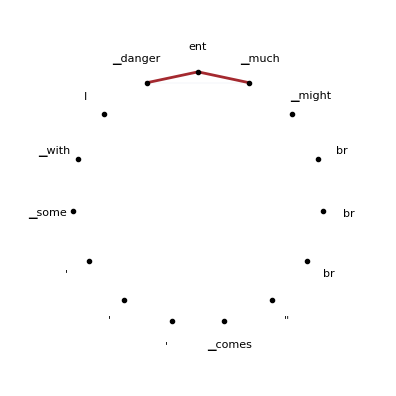

In [20]:
from matplotlib.collections import LineCollection
# Rescale edge weights for visibility
factor = 1 / np.max([np.max(ew) for ew in edge_weights_to_plot])
ewtp_rescaled = [[ew * factor for ew in edge_weights] for edge_weights in edge_weights_to_plot]
# Plot 
words = [tokens_to_plot[1][1]] + tokens_to_plot[2]
print(words)
fig, ax = plt.subplots(figsize=(4,4))
# Draw words
theta = np.linspace(0, 360, 15, endpoint=False)
x = np.cos(np.radians(theta) + np.pi/2)
y = np.sin(np.radians(theta) + np.pi/2)
text_radius = 1.2
ax.plot(x, y, 'k.')
for i in range(len(words)):
    word = words[i]
    ax.annotate(word, (-x[i]*text_radius, y[i]*text_radius), size=8, ha='center', va='center')
# Draw 1.2 attention
# ax.plot([x[1], x[-1]], [y[1], y[-1]], c="#2E63A6", lw=2, zorder=-3)
ax.plot([x[1], x[-1]], [y[1], y[-1]], c="#2E63A6", lw=ewtp_rescaled[0][0], zorder=-3)
# Draw 2.0 attention
# ax.plot([x[1], x[0], x[-1]], [y[1], y[0], y[-1]], c="#A4292F", lw=2, zorder=-3)
ax.plot([x[1], x[0], x[-1]], [y[1], y[0], y[-1]], c="#A4292F", lw=2, zorder=-3)
# Draw DP attention
# ax.plot(x[1:], y[1:], c="#636363", lw=2, zorder=-3)
plt.axis("equal")
plt.xlim([-1.5, 1.5])
plt.ylim([-1.5, 1.5])
plt.axis("off")
plt.tight_layout()
plt.show()

['ent', '▁much', '▁might', 'br', 'br', 'br', '"', '▁comes', "'", "'", "'", '▁some', '▁with', 'I', '▁danger']


Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


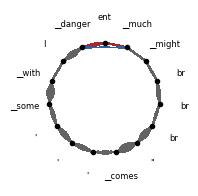

In [21]:
from matplotlib.collections import LineCollection

def taper_linecollection(lc, end_width, mid_widths, n_subsegments=100):
    """
    Modify a LineCollection so each line tapers:
    - linewidth = 2 at the ends (nodes)
    - linewidth = mid_widths[i] at the middle
    
    Parameters
    ----------
    lc : LineCollection
        The existing line collection (with N segments).
    mid_widths : list or array-like of length N
        Target linewidth at the midpoint of each line.
    n_subsegments : int
        How many subsegments to split each line into (for smooth taper).
    
    Returns
    -------
    new_lc : LineCollection
        A new LineCollection with tapered linewidths applied.
    """
    segments = lc.get_segments()
    new_segments = []
    new_linewidths = []
    
    for seg, mid_w in zip(segments, mid_widths):
        (x0, y0), (x1, y1) = seg
        # Interpolated points along the edge
        t = np.linspace(0, 1, n_subsegments+1)
        xs = np.linspace(x0, x1, n_subsegments+1)
        ys = np.linspace(y0, y1, n_subsegments+1)
        
        # Build subsegments
        pts = np.array([xs, ys]).T.reshape(-1, 1, 2)
        segs = np.concatenate([pts[:-1], pts[1:]], axis=1)

        # Linewidth profile: end_width at ends, mid_w at center
        lw_profile = end_width + (mid_w - end_width) * np.sin(np.pi * t[:-1])**2

        new_segments.extend(segs)
        new_linewidths.extend(lw_profile)
    
    new_lc = LineCollection(new_segments, linewidths=new_linewidths, colors=lc.get_colors(), antialiased=False, zorder=lc.get_zorder())
    return new_lc

def create_lc(X, Y, zorder=1):
    points = np.array([X, Y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    return LineCollection(segments, linewidths=2, zorder=zorder)
# Rescale edge weights for visibility
# ewtp_rescaled = [[1/ew for ew in edge_weights] for edge_weights in edge_weights_to_plot]
# factor = 1 / np.max([np.max(ew) for ew in ewtp_rescaled])
# ewtp_rescaled = [[ew * factor for ew in edge_weights] for edge_weights in ewtp_rescaled]
factor = 1 / np.min([np.min(ew) for ew in edge_weights_to_plot])
ewtp_rescaled = [[ew * factor * 0.25 for ew in edge_weights] for edge_weights in edge_weights_to_plot]
# Plot 
words = [tokens_to_plot[1][1]] + tokens_to_plot[2]
print(words)
fig, ax = plt.subplots(figsize=(2,2))
# Draw words
theta = np.linspace(0, 360, 15, endpoint=False)
x = np.cos(np.radians(theta) + np.pi/2)
y = np.sin(np.radians(theta) + np.pi/2)
text_radius = 1.45
ax.plot(x, y, 'k.', zorder=5)
for i in range(len(words)):
    word = words[i]
    ax.annotate(word, (-x[i]*text_radius, y[i]*text_radius), size=6, ha='center', va='center')
# Draw 1.2 attention
X = np.array([x[1], x[-1]])
Y = np.array([y[1], y[-1]])
lc = create_lc(X,Y, zorder=3)
lc.set_color("#2E63A6")
# lc.set_alpha(ewtp_rescaled[0])
# lc.set_linewidths(ewtp_rescaled[0])
lc = taper_linecollection(lc, 1, ewtp_rescaled[0], n_subsegments=500)
ax.add_collection(lc)
# ax.plot([x[1], x[-1]], [y[1], y[-1]], c="#2E63A6", lw=2, zorder=-3)
# Draw 2.0 attention
# ax.plot([x[1], x[0], x[-1]], [y[1], y[0], y[-1]], c="#A4292F", lw=2, zorder=-3)
X = np.array([x[1], x[0], x[-1]])
Y = np.array([y[1], y[0], y[-1]])
lc = create_lc(X,Y)
lc.set_color("#A4292F")
# lc.set_alpha(ewtp_rescaled[1])
# lc.set_linewidths(ewtp_rescaled[1])
lc = taper_linecollection(lc, 1, ewtp_rescaled[1], n_subsegments=500)
ax.add_collection(lc)
# Draw DP attention
# ax.plot(x[1:], y[1:], c="#636363", lw=2, zorder=-3)
X = np.array(x[1:])
Y = np.array(y[1:])
lc = create_lc(X,Y)
lc.set_color("#636363")
# lc.set_alpha(ewtp_rescaled[2])
# lc.set_linewidths(ewtp_rescaled[2])
lc = taper_linecollection(lc, 1, ewtp_rescaled[2], n_subsegments=500)
ax.add_collection(lc)
plt.axis("equal")
plt.xlim([-1.6, 1.6])
plt.ylim([-1.6, 1.6])
plt.axis("off")
plt.tight_layout()
from constants import FIGS_DIR
SAVE_DIR = njoin(FIGS_DIR, 'nlp-mechanisms')    
fig_file = 'shortest_path_example'
fig_file += '.pdf'
plt.savefig(njoin(SAVE_DIR, fig_file), bbox_inches='tight')
plt.show()

# Mean spectral gaps

In [ ]:
# only for testing, does not affect results after this cell

# paths = [".droot/L-d-grid/1L-hidden=8-max_len=512-rescaled/config_qqv/imdb/layers=1-heads=1-qqv/oprdfnsformer-imdb-qqv-alpha=1.2-eps=1.0/model=0/andrew_results_2.npz",
#          ".droot/L-d-grid/1L-hidden=8-max_len=512-rescaled/config_qqv/imdb/layers=1-heads=1-qqv/oprdfnsformer-imdb-qqv-alpha=2.0-eps=1.0/model=0/andrew_results_2.npz",
#         ".droot/L-d-grid/1L-hidden=8-max_len=512-rescaled/config_qqv/imdb/layers=1-heads=1-qqv/opdpformer-imdb-qqv/model=0/andrew_results_2.npz"]

paths = [".droot/L-d-grid-v2/1L-hidden=8-max_len=512-rescaled/config_qqv/imdb/layers=1-heads=1-qqv/oprdfnsformer-imdb-qqv-alpha=1.2-eps=1.0/model=0/andrew_results_2.npz",
         ".droot/L-d-grid-v2/1L-hidden=8-max_len=512-rescaled/config_qqv/imdb/layers=1-heads=1-qqv/oprdfnsformer-imdb-qqv-alpha=2.0-eps=1.0/model=0/andrew_results_2.npz",
        ".droot/L-d-grid-v2/1L-hidden=8-max_len=512-rescaled/config_qqv/imdb/layers=1-heads=1-qqv/opdpformer-imdb-qqv/model=0/andrew_results_2.npz"]


for i in range(3):
    path = paths[i]
    mean_spectral_gaps = np.load(paths[i])["mean_spectral_gaps"]

In [47]:
# for checking the spectrum

seed = 4
model_root = '.droot/L-d-grid-v2/1L-hidden=8-max_len=512-rescaled/config_qqv/imdb/layers=1-heads=1-qqv'
paths = [f"{model_root}/oprdfnsformer-imdb-qqv-alpha=1.2-eps=1.0/model=0/spectrum_file.npz",
         f"{model_root}/oprdfnsformer-imdb-qqv-alpha=2.0-eps=1.0/model=0/spectrum_file.npz",
         f"{model_root}/opdpformer-imdb-qqv/model=0/spectrum_file.npz"]

eidx = 10
for i in range(len(paths)):
    path = paths[i]
    spectrum = np.load(paths[i])["spectrum"]

    print(spectrum.shape)
    i_max = np.where(spectrum[eidx,:] == spectrum[eidx,:].max())[0].item()
    print(i_max)
    print(spectrum[eidx,:].max())
    print(spectrum[eidx,:i_max].max())
    print('\n')
#     print(spectrum[0,i_max-10:i_max+1])
#     print(spectrum[0,i_max])
#     print(spectrum[0,i_max-1])
#     print(spectrum[0,i_max:])

(100, 512)
479
1.0
0.1154136210680008


(100, 512)
479
1.0
0.46573010087013245


(100, 512)
479
1.0000001192092896
0.9997337460517883




# Mean spectral gap vs Accuracy

In [ ]:
# getting the model performances
# def get_all_test_results():
is_rescale_dist=True
fns_manifold='rd'
models_root = ".droot/L-d-grid-v2/"
qk_shares = [True]
selected_alphas='1.0,1.2,1.4,1.6,1.8,2'
metric='val_acc'
selected_dataset='imdb'
is_op=True

fns_type = fns_manifold + 'fns' + MODEL_SUFFIX 
other_model_type = 'dpformer'
if is_op:
    fns_type = 'op' + fns_type
    other_model_type = 'op' + other_model_type
model_types_to_plot = [fns_type, other_model_type]

is_op, is_rescale_dist = str2bool(is_op), str2bool(is_rescale_dist)
qk_shares = str2ls(qk_shares)        
selected_alphas = [float(selected_alpha) for selected_alpha in str2ls(selected_alphas)]
eps = 1

# Regular expression pattern
pattern = r"\d+L-hidden=\d+-max_len=512"
if is_rescale_dist:            
    pattern += "-rescaled"

# Extract matching subfolders
layer_dirs_dict = {}
layers, emb_ds = [], []
for layer_dir in os.listdir(models_root):
    is_match = re.fullmatch(pattern, layer_dir)
    if is_match:
        #layer, emb_d = int(is_match.group(1)), int(is_match.group(2))
        layer = int(layer_dir.split('L')[0])          
        #emb_d = int(layer_dir.split('-')[1].split('=')[1])
        emb_d = int(layer_dir.split('-')[1].split('=')[1])  
        if isdir(njoin(models_root, layer_dir)):
            layer_dirs_dict[f'{layer}-{emb_d}'] = njoin(models_root, layer_dir)
        layers.append(layer)
        emb_ds.append(emb_d)
layers = np.array(sorted(list(set(layers)))); layers = layers[layers < 2]
emb_ds = np.array(sorted(list(set(emb_ds)))); emb_ds = emb_ds[emb_ds < 65]

#nrows, ncols = len(qk_shares), len(selected_alphas)
nrows, ncols = len(qk_shares), len(layers)

# (model_types, qk_share, L, d_model)
N_model_types = len(selected_alphas) + 1
metric_matrix = np.zeros([nrows, N_model_types, len(layers), len(emb_ds), 5])
gap_matrix = np.zeros([nrows, N_model_types, len(layers), len(emb_ds), 5])

# average_metric_matrix = np.zeros([nrows, N_model_types, len(layers), len(emb_ds)])
# std_metric_matrix = np.zeros([nrows, N_model_types, len(layers), len(emb_ds)])
# average_metric_matrix[:] = np.nan
# std_metric_matrix[:] = np.nan
model_types_plotted = []
for (qk_ii,qk_share),(layer_idx,layer),(emb_d_idx,emb_d) in\
        product(enumerate(qk_shares),enumerate(layers),enumerate(emb_ds)):

    qk_share_dirname = 'config_qqv' if qk_share else 'config_qkv'
    print(f'qk_share = {qk_share}, layer = {layer}, emb_d = {emb_d}')    
    # directories matching the above setting in the triple for loop
    if f'{layer}-{emb_d}' in layer_dirs_dict.keys():
        if qk_share_dirname in os.listdir(layer_dirs_dict[f'{layer}-{emb_d}']):
            setting_dir = njoin(layer_dirs_dict[f'{layer}-{emb_d}'], qk_share_dirname)
        else:
            continue
    else:
        continue
    # for _ in range(2):
    #     setting_dir = njoin(setting_dir, os.listdir(setting_dir)[0])
    setting_dir = njoin(setting_dir, 'imdb')
    setting_dir = njoin(setting_dir, os.listdir(setting_dir)[0])
    DCT_ALL = collect_model_dirs(setting_dir, suffix=MODEL_SUFFIX)
    model_df = DCT_ALL[fns_type].dropna(subset='alpha')
    model_df.reset_index(drop=True, inplace=True)

    for model_type in model_types_to_plot:
        if model_type in DCT_ALL.keys():
            df_model = DCT_ALL[model_type]
        else:
            continue
        condition0 = (df_model['ensembles']>0)&(df_model['qk_share']==qk_share)&\
                     (df_model['is_op']==is_op)&(df_model['model_dir'].str.contains(selected_dataset))&\
                     (df_model['model_dir'].str.contains(f'{model_type}-'))
        matching_df = df_model[condition0]

        if model_type not in model_types_plotted:
            model_types_plotted.append(model_type)
        lstyle_model = LINESTYLE_DICT[model_type]            
        for alpha_idx, alpha in enumerate(selected_alphas):  
            # if is fns type
            is_fns = 'fns' in model_type
            alpha = alpha if is_fns else None
            matching_df.reset_index(drop=True, inplace=True)

            # -------------------- SINK, DP -------------------- 
            model_info = matching_df 
            # -------------------- FNS --------------------
            if is_fns:
                condition = (matching_df['alpha']==alpha) & (matching_df['bandwidth']==eps)
                model_info = model_info[condition]
            else:
                alpha_idx = len(selected_alphas)

            # load model performance
            if model_info.shape[0] > 0:
                seeds, qk_share = (model_info[k].item() for k in ('seeds', 'qk_share'))                
                epochs, run_perf_all = load_seed_runs(model_info['model_dir'].item(), seeds, metric)   
            else:
                continue
            if run_perf_all is not None:
                metric_matrix[qk_ii, alpha_idx, layer_idx, emb_d_idx, :] = run_perf_all.loc[run_perf_all.index[-1]:, metric]

            # load mean spectral gap

            for seed in seeds:
                gap_matrix[qk_ii, alpha_idx, layer_idx, emb_d_idx, seed] =\
                    np.load(njoin(model_info['model_dir'].item(), 
                                  f'model={seed}', 'andrew_results_2.npz'))["mean_spectral_gaps"].item() 

            if not is_fns:
                break  # only do once if model is NOT FNS type   
    # return metric_matrix, gap_matrix

# metric_matrix = get_all_test_results()
# metric_matrix, gap_matrix = get_all_test_results()   

qk_share = True, layer = 1, emb_d = 8


u:\scratch\uu69\cq5024\projects\fractional-attn\nlp-tutorial\UTILS\mutils.py:223: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = df._append(model_dir_dct, ignore_index=True)


qk_share = True, layer = 1, emb_d = 16


u:\scratch\uu69\cq5024\projects\fractional-attn\nlp-tutorial\UTILS\mutils.py:223: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = df._append(model_dir_dct, ignore_index=True)


qk_share = True, layer = 1, emb_d = 32


u:\scratch\uu69\cq5024\projects\fractional-attn\nlp-tutorial\UTILS\mutils.py:223: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = df._append(model_dir_dct, ignore_index=True)


qk_share = True, layer = 1, emb_d = 64


u:\scratch\uu69\cq5024\projects\fractional-attn\nlp-tutorial\UTILS\mutils.py:223: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = df._append(model_dir_dct, ignore_index=True)


In [75]:
# metric_matrix = np.zeros([nrows, N_model_types, len(layers), len(emb_ds), 5])
# gap_matrix = np.zeros([nrows, N_model_types, len(layers), len(emb_ds), 5])

print(gap_matrix)

[[[[[ 4.94591380e-05  4.58619138e-05  4.65706876e-05  4.60880389e-05
      4.55875648e-05]
    [ 4.23756754e-05  4.36124299e-05  4.17397404e-05  4.32094652e-05
      4.52008424e-05]
    [ 3.54244607e-05  3.97519278e-05  3.82473087e-05  4.17364156e-05
      4.04327922e-05]
    [ 3.42082535e-05  3.14858090e-05  3.55070620e-05  3.46399704e-05
      3.39543098e-05]]]


  [[[ 4.92288684e-05  5.03506837e-05  4.67575714e-05  4.88731638e-05
      4.80951043e-05]
    [ 4.54027671e-05  4.10073204e-05  4.26006783e-05  4.33464535e-05
      4.20511328e-05]
    [ 3.68851819e-05  3.88954440e-05  4.00061929e-05  3.86574678e-05
      3.74589162e-05]
    [ 3.42289335e-05  4.04278818e-05  3.46995168e-05  3.38909612e-05
      3.54534667e-05]]]


  [[[ 5.08999918e-05  5.51018212e-05  4.83930763e-05  4.70870221e-05
      4.64676274e-05]
    [ 4.37786197e-05  4.38367622e-05  4.61195456e-05  4.26588114e-05
      4.26253816e-05]
    [ 3.48637346e-05  3.83416493e-05  3.71862063e-05  4.12732200e-05
      3.95281

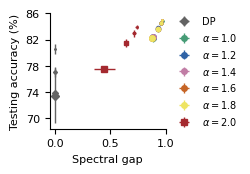

In [9]:
# update version
%matplotlib inline
from matplotlib.colors import to_rgb

# data = np.load(".droot/all_spectral_gap.npz")
# spectral_gap = data["spectral_gap"]

# X_lens = data["X_lens"]
# alphas = data["alphas"]
# dimensions = data["dimensions"]

# metric_matrix = get_all_test_results()
# metric_matrix, spectral_gap = get_all_test_results()
spectral_gap = gap_matrix[0,:,0,:,:]  # [model_types, emb_ds, seeds]
alphas = [1.0, 1.2, 1.4, 1.6, 1.8, 2, None]
    
colors = ["#636363", "#469C76", "#2E63A6", "#C17DA5", "#C66526", "#EEE461", "#A4292F"]
# marker_alphas = [1, 0.8, 0.6, 0.4]
marker_alphas = [1] * 4
marker_sizes = [8,6,4,2]
fig, ax = plt.subplots(figsize=(1.5,1.5))
for model_idx in range(7):
    if model_idx == 0: # DPformer
        idx = -1
    else:
        idx = model_idx - 1
    test_accs = np.mean(metric_matrix[0,idx,0,:,:], axis=-1)
    # ----- [nrows, N_model_types, len(layers), len(emb_ds), 5] -----
    # gap = np.mean(spectral_gap[model_idx, :, :], axis=-1)
    gap = np.mean(spectral_gap[idx, :, :], axis=-1)
    color = colors[model_idx]
    r, g, b = to_rgb(color)
    color = np.array([(r, g, b, alpha) for alpha in marker_alphas])
    # xerr = np.std(spectral_gap[model_idx, :, :], axis=-1)
    xerr = np.std(spectral_gap[idx, :, :], axis=-1)
    yerr = np.std(metric_matrix[0,idx,0,:,:], axis=-1)
    # ax.scatter(gap, test_accs, clip_on=False, label='DP' if model_idx==0 else rf'$\alpha={alphas[idx]:.1f}$', color=color, s=marker_sizes)
    if model_idx == 0:
        marker_style = 'D'
        size_factor = 0.5
    elif model_idx == 6:
        marker_style = 's'
        size_factor = 0.5
    else:
        marker_style = '.'
        size_factor = 1
    for plot_idx, (s, g, ta, xe, ye) in enumerate(zip(marker_sizes, gap, test_accs, xerr, yerr)):
        if plot_idx == 0:
            ax.errorbar(g, ta, xerr=xe, yerr=ye, fmt=marker_style, c=color[0], markersize=s*size_factor, label='DP' if model_idx==0 else rf'$\alpha={alphas[idx]:.1f}$', elinewidth=1)
        else:
            ax.errorbar(g, ta, xerr=xe, yerr=ye, fmt=marker_style, c=color[0], markersize=s*size_factor, elinewidth=1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylim(top=86)
# ax.set_yticks([78, 82, 86])
ax.set_yticks(list(range(70, 87, 4)))
ax.set_xlim(right=1)
# ax.set_xlim(right=0.18)
# ax.set_xticks([0, 0.06, 0.12, 0.18])
ax.set_xlabel('Spectral gap')
ax.set_ylabel('Testing accuracy (%)')
ax.legend(frameon=False, bbox_to_anchor=(1, 1.05))
from constants import FIGS_DIR
SAVE_DIR = njoin(FIGS_DIR, 'nlp-mechanisms')  
if not isdir(SAVE_DIR): makedirs(SAVE_DIR)  
plt.savefig(njoin(SAVE_DIR, "spectral_gap_vs_acc.pdf"), bbox_inches='tight')
plt.show()

# Mean shortest path for various seq length

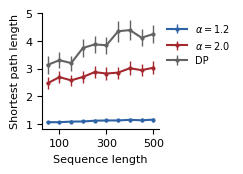

In [41]:
%matplotlib inline
# paths = [".droot/attn_graph_results_1.2.npz", ".droot/attn_graph_results_2.0.npz", ".droot/attn_graph_results_dp.npz"]

seed = 4
d = 8
shared_path = f'.droot/L-d-grid-v2/1L-hidden={d}-max_len=512-rescaled/config_qqv/imdb/layers=1-heads=1-qqv'
paths = [f"{shared_path}/oprdfnsformer-imdb-qqv-alpha=1.2-eps=1.0/model={seed}/attn_graph_results.npz",
         f"{shared_path}/oprdfnsformer-imdb-qqv-alpha=2.0-eps=1.0/model={seed}/attn_graph_results.npz",
         f"{shared_path}/opdpformer-imdb-qqv/model={seed}/attn_graph_results.npz"]
seq_lens = np.arange(50, 501, 50)

plt.close('all')
fig, ax = plt.subplots()
fig.set_size_inches(1.5,1.5)
colors = ["#2E63A6", "#A4292F", "#636363"]
for i, path in enumerate(paths):
    data = np.load(path)
    shortest_path_lengths = data["shortest_path_lengths"]
    shortest_path_lengths[shortest_path_lengths == 0] = np.nan
    mean_shortest_path_lengths = np.nanmean(shortest_path_lengths, axis=-1)
    std_shortest_path_lengths = np.nanstd(shortest_path_lengths, axis=-1)
    ax.errorbar(seq_lens, mean_shortest_path_lengths, yerr=std_shortest_path_lengths/5, label='DP' if 'dp' in path else (r'$\alpha=1.2$' if '1.2' in path else r'$\alpha=2.0$'), elinewidth=1, color=colors[i], marker='o', markersize=2)
ax.legend(frameon=False, bbox_to_anchor=(1, 1))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('Sequence length')
ax.set_ylabel('Shortest path length')
ax.set_yticks([1,2,3,4,5])
ax.set_xticks([100, 300, 500])
from constants import FIGS_DIR
SAVE_DIR = njoin(FIGS_DIR, 'nlp-mechanisms')  
if not isdir(SAVE_DIR): makedirs(SAVE_DIR)   
plt.savefig(njoin(SAVE_DIR, f"shortest_path_length_vs_seq_len-seed={seed}.pdf"), bbox_inches='tight')
plt.show()